# Alleles Report

Given a set of gene trees that have multiple tips per species, identify whether the tips are monophyletic, and the corresponding bootstrap value. If they are not monophyletic, identify the last common ancestor preventing their monophyly and record that bootstrap value (as a negative). 

Then, create a heatmap where each species is a row and each gene is a column. The value of each cell varies from -1 (support for nonmonophyly) to +1 (support for monophyly or homozygous). Negative values will be red to white as they approach zero, and postitive values will be blue to white as they approach zero.

In [1]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 6)
import os
from ete3 import Tree, TreeStyle, TextFace,NodeStyle,faces, COLOR_SCHEMES
import pandas as pd
import numpy as np
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
genetree_path = "/Users/mjohnson/Desktop/Projects/BREAD/alleles_paper/For_Matt/alleles_bipart_trees"
id_to_sp = pd.read_csv("/Users/mjohnson/Desktop/Projects/BREAD/alleles_paper/namelist_ajb.txt",sep="\t",header=0,index_col=0)
namelist=id_to_sp.index
os.chdir(genetree_path)


Function for rerooting the tree using the outgroup sequence(s). There may be one or two alleles for the outgroup.


In [3]:
def reroot_tree(t):
    outgroups_in_tree = [x for x in list(t.get_leaf_names()) if x.startswith("EG78")]
    ancestor = t.get_common_ancestor(outgroups_in_tree)
    if len(outgroups_in_tree) > 1:
        if ancestor == t:
            ingroups_in_tree = list(set(t.get_leaf_names()).difference(set(outgroups_in_tree)))
            ancestor = t.get_common_ancestor(ingroups_in_tree)
            t.set_outgroup(ancestor)
        else:
            t.set_outgroup(ancestor)
    else:
        t.set_outgroup(outgroups_in_tree[0])
    return t


Function for determining whether alleles for a species are monophyletic, homozygous or missing. If they are monophyletic, return the support value for the common ancestor. If they are paraphyletic, use a different function to determine the support for non-monophyly.

In [4]:
def find_non_monophyly_support(tree,allele_names,allele_monophyly):
    allele_ancestor = tree.get_common_ancestor(allele_names)
    between_leaves = allele_monophyly[2]
    conflicting_support = []
    for n in allele_ancestor.iter_descendants():
        for leaf in n.get_leaf_names():
            if leaf in allele_names and not n.is_leaf():
                conflicting_support.append(n.support)
    return(-max(conflicting_support)/100)




def get_sister_dict(tree_fn,namelist):
    tree = Tree(tree_fn)
    tree = reroot_tree(tree)
    taxon_dict = {x:np.nan for x in namelist}
    for taxon in namelist:
        allele_names = []
        for leaf in tree:
            if taxon in leaf.name:
                allele_names.append(leaf.name)
        if len(allele_names) == 0:
            taxon_dict[taxon] = np.nan
        elif len(allele_names) == 1:
            taxon_dict[taxon] = 2
        else:
            allele_monophyly = tree.check_monophyly(allele_names,target_attr='name')
            #print(taxon,allele_monophyly)
            if allele_monophyly[0]:
                species_node = tree.get_common_ancestor(allele_names)
                taxon_dict[taxon] = species_node.support/100
            else:
                taxon_dict[taxon] = find_non_monophyly_support(tree,allele_names,allele_monophyly)
    return pd.Series(taxon_dict)

    
      

In [5]:
allele_report = pd.DataFrame()
treefiles = [x for x in os.listdir(genetree_path) if x.startswith("RAxML")]
for tree_fn in treefiles:
    allele_report[tree_fn] = get_sister_dict(os.path.join(genetree_path,tree_fn),namelist)
row_order = id_to_sp.sort_values("Genus").index    
allele_report=allele_report.reindex(row_order)

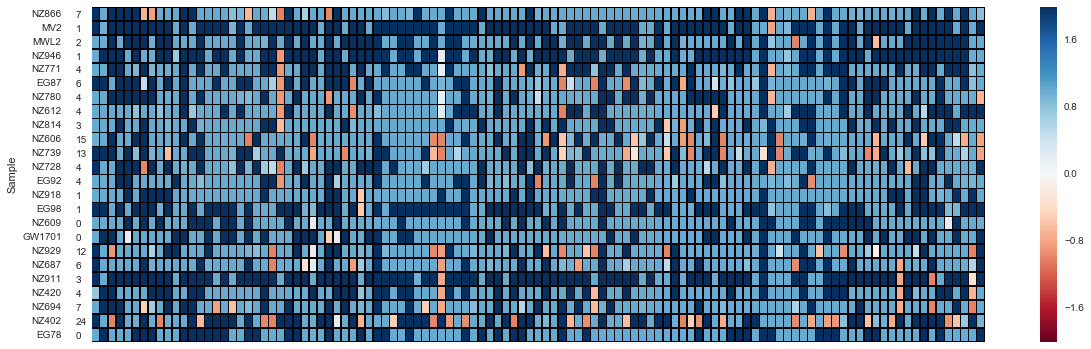

In [6]:
figsize(20, 6)
ax = sns.heatmap(allele_report,xticklabels=False,cmap="RdBu",mask=np.isnan(allele_report),vmin=-1,vmax=2,linewidths=0.5,linecolor='black')
#sns.heatmap(allele_report,xticklabels=False,cmap="RdBu",mask=allele_report > 1,vmin=-1,vmax=1,linewidths=0.5,linecolor='black')
ax.tick_params(axis='y', which='major', pad=30)
for i in range(len(allele_report.index)):
    num_conflicting_50 = sum(allele_report.loc[allele_report.index[i]].apply(lambda x: x < -0.5))
    #print(allele_report.index[i],num_conflicting_50)
    ax.text(-2,23-i+0.25,num_conflicting_50, fontsize=10, rotation=0)


In [7]:
ax.get_figure().savefig("alleles_heatmap.svg")

Next, we will summarize deep coalescence across the gene trees and the relationship between deep coalescence and overall gene tree resolution. First, a function to determine gene tree resolution.

In [8]:
def gene_tree_resolution(tree_fn):
    num_removed = 0
    tree = Tree(tree_fn)
    tree = reroot_tree(tree)
    #support_values = [node.support for node in tree.traverse()]
    #percent_resolution = median(support_values)
    #support_values = [node.support for node in tree.traverse() if node.support >= 50]
    
    support_values = []
    for node in tree.traverse():
        node_leaves = node.get_leaves()
        if len(node_leaves) == 2:
            tip_species = [n.name.split("_")[0] for n in node_leaves]
            if len(set(tip_species)) > 1 and  node.support >= 50:
                support_values.append(node.support)
            else:
                num_removed += 1
        else:
            if node.support >= 50:
                support_values.append(node.support)
    
    
    percent_resolution = len(support_values) / (len(tree) - 1 -num_removed)
    return percent_resolution

treefiles = [x for x in os.listdir(genetree_path) if x.startswith("RAxML")]
resolution_dict = {}
deepcoal_dict = {}

for tree_fn in treefiles[0:]:
    resolution_dict[tree_fn]=gene_tree_resolution(os.path.join(genetree_path,tree_fn))
    deepcoal_dict[tree_fn] = sum(allele_report[tree_fn].apply(lambda x: x >= -0.5))/24

deepcoal_vs_resolution = pd.concat([pd.Series(resolution_dict),pd.Series(deepcoal_dict)],axis=1)
deepcoal_vs_resolution.columns=["ResolutionAlleles","PctMonophyletic"]
    
    

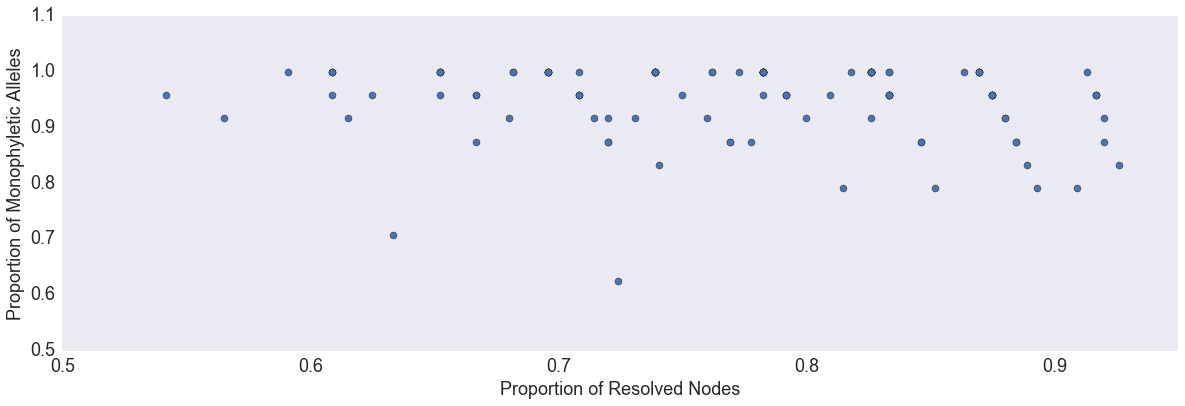

In [9]:
#figsize(6, 6)
dvr = deepcoal_vs_resolution.plot(x="ResolutionAlleles",y="PctMonophyletic",kind='scatter',grid=False,s=50,fontsize=18)
dvr.set(xlabel='Proportion of Resolved Nodes', ylabel='Proportion of Monophyletic Alleles')
dvr.yaxis.label.set_size(18)
dvr.xaxis.label.set_size(18)
dvr.get_figure().savefig('deepcoal_vs_resolution.svg')

Finally we want to track the resolution of each gene tree across the datasets. First we need to calcualte the resolution for the other two datasets

In [10]:
consensus_path = "/Users/mjohnson/Desktop/Projects/BREAD/alleles_paper/For_Matt/consensus_bipart_trees"
treefiles = [x for x in os.listdir(consensus_path) if x.startswith("RAxML")]
consensus_resolution = {}
for tree_fn in treefiles:
    consensus_resolution[tree_fn]=gene_tree_resolution(os.path.join(consensus_path,tree_fn))
deepcoal_vs_resolution["ResolutionConsensus"] = pd.Series(consensus_resolution)

ambiguity_path = "/Users/mjohnson/Desktop/Projects/BREAD/alleles_paper/For_Matt/ambiguity_bipart_trees"
treefiles = [x for x in os.listdir(ambiguity_path) if x.startswith("RAxML")]
ambiguity_resolution = {}
for tree_fn in treefiles:
    ambiguity_resolution[tree_fn]=gene_tree_resolution(os.path.join(ambiguity_path,tree_fn))
deepcoal_vs_resolution["ResolutionAmbiguity"] = pd.Series(ambiguity_resolution)
#deepcoal_vs_resolution= deepcoal_vs_resolution.reset_index()


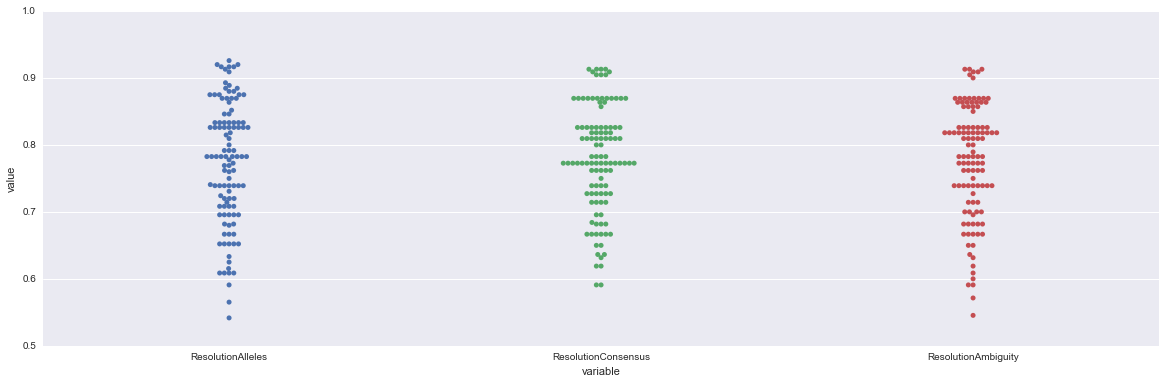

In [11]:
resolution_by_dataset=pd.melt(deepcoal_vs_resolution.drop("PctMonophyletic",axis=1))
sns.swarmplot(data=resolution_by_dataset,x="variable",y="value")
resolution_by_dataset["Tree"]=list(deepcoal_vs_resolution.index)*3

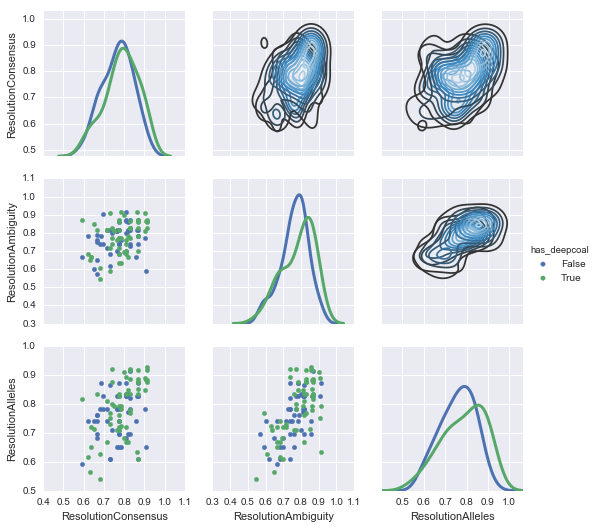

In [12]:
#ax = sns.boxplot(data=deepcoal_vs_resolution.drop("PctMonophyletic",axis=1))
figsize=(20,20)
deepcoal_vs_resolution["has_deepcoal"] = deepcoal_vs_resolution.PctMonophyletic < 1
pairgrid = sns.PairGrid(data=deepcoal_vs_resolution,
                  vars=["ResolutionConsensus","ResolutionAmbiguity","ResolutionAlleles"],
                 hue="has_deepcoal")
pairgrid.map_diag(sns.kdeplot, lw=3);
pairgrid.map_upper(sns.kdeplot, cmap="Blues_d")
pairgrid.map_lower(plt.scatter)
pairgrid.add_legend()
#ax.lines()

In [103]:
pairgrid.savefig("coalescence_vs_resolution.svg")

In [18]:
import scipy.stats as stats
stats.ttest_rel(a = deepcoal_vs_resolution.ResolutionConsensus,
                b = deepcoal_vs_resolution.ResolutionAmbiguity)

Ttest_relResult(statistic=0.39883991659693308, pvalue=0.69078435473388289)

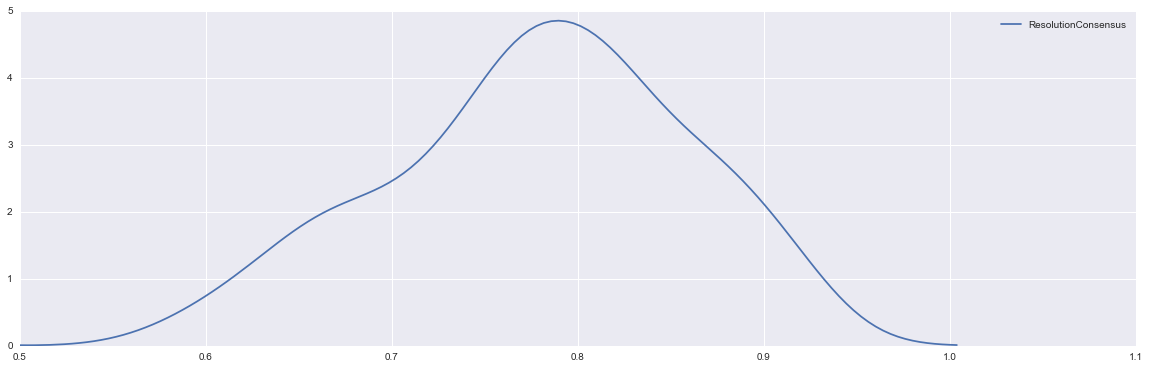

In [23]:
sns.kdeplot(deepcoal_vs_resolution.ResolutionConsensus)